In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import f1_score

sns.set_theme(context = 'notebook', style = 'darkgrid')

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Métodos de Classificação II

Vamos avançar nossos estudos sobre métodos de classificação analisando dois novos algoritmos da categoria de *Modelos de Ensemble* (*bagging* e *boosting*). Além disso teremos o primeiro contato com os conceitos de *underfitting* e *overfitting*, e como esses conceitos se relacionam com a **complexidade** dos modelos de ML.

In [3]:
tb_hotel_train = pd.read_csv("data/tb_hotel_train_clean.csv")
tb_hotel_test = pd.read_csv("data/tb_hotel_test_clean.csv")
tb_hotel_train.head()


,lead_time,adults,children_imp,num_meal,adr,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,...,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA,is_company,is_cancelled
0,-0.619738,0.265892,-0.261362,-0.050467,-0.582983,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-0.085516,0.265892,-0.261362,-0.050467,-0.193021,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.507270,0.265892,-0.261362,-0.050467,-1.183915,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.554132,0.265892,-0.261362,-0.050467,-0.319759,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.701759,0.265892,-0.261362,1.856256,-0.310010,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [4]:
x_var = ["lead_time", "adr"]
X_train = tb_hotel_train[x_var]
X_test = tb_hotel_test[x_var]
y_train = tb_hotel_train["is_cancelled"]
y_test = tb_hotel_test["is_cancelled"]


Para facilitar a visualização dos nossos modelos continuaremos nos restringindo à duas variáveis: `lead_time` e `adr`. Vamos criar dois DataFrames para visualizar separadamente os efeitos de cada variável sobre **a função de probabilidade** estimada por cada algoritmo:

In [5]:
lead_time_simul = list(np.linspace(-1, 3, 100)) * 3
adr_simul = [-1] * 100 + [0] * 100 + [1] * 100
tb_simul_lt = pd.DataFrame({'lead_time' : lead_time_simul, 'adr' : adr_simul})
tb_simul_lt.head()

,lead_time,adr
0,-1.000000,-1
1,-0.959596,-1
2,-0.919192,-1
3,-0.878788,-1
4,-0.838384,-1


In [6]:
adr_simul = list(np.linspace(-2, 2, 100)) * 3
lead_time_simul = [-1] * 100 + [0] * 100 + [1] * 100
tb_simul_adr = pd.DataFrame({'lead_time' : lead_time_simul, 'adr' : adr_simul})
tb_simul_adr.head()

,lead_time,adr
0,-1,-2.000000
1,-1,-1.959596
2,-1,-1.919192
3,-1,-1.878788
4,-1,-1.838384


Vamos criar um DataFrame com os dados originais de teste para guardarmos as diferentes previsões de nossos modelos:

In [7]:
tb_fits = X_test.copy()
tb_fits["is_cancelled"] = y_test

# Complexidade e Overfitting

Para avaliarmos melhor a relação entre complexidade e overfitting, vamos carregar mais variáveis de nosso dataset:

In [8]:
train_of = pd.read_csv('data/tb_hotel_train_overfit.csv')
test_of = pd.read_csv('data/tb_hotel_test_overfit.csv')

X_train_of = train_of.drop('is_cancelled', axis = 1)
X_test_of = test_of.drop('is_cancelled', axis = 1)
y_train_of = train_of['is_cancelled']
y_test_of = test_of['is_cancelled']

Como vimos no começo do Módulo III, podemos dividir a utilização dos algoritmos de ML em duas etapas:

* **Aprendizagem**, onde o algoritmo *aprende* as relações entre nossas *features* e a *variável resposta* utilizando dados históricos (representados pelo conjunto de treinamento);
* **Predição**, onde utilizamos os padrões *aprendidos* pelo algoritmo para realizar projeções sobre novos dados a partir de nossos *features* (represetado pelo conjunto de teste).

A **fase de aprendizagem** consiste na otimização do erro de projeção sobre o conjunto de treinamento - o modelo ajusta gradualmente seus coeficientes buscando melhorar a cada etapa seu erro de projeção sobre os dados históricos. Conforme aumentamos a **complexidade** do modelo essa otimização torna-se cada vez mais eficiente. 

Isso não significa, necessariamente, que o erro de previsão do modelo melhorará! Conforme a **complexidade** aumenta, o modelo perde a **capacidade de generalização**: ao invés de *encontrar padrões* nos dados históricos ele aprende regras que se aplicam somente às observações do conjunto de treinamento.

Vamos utilizar uma árvore de decisão para visualizar este processo:

In [10]:
from sklearn.tree import DecisionTreeClassifier

As árvores de decisão tem um parâmetro de complexidade muito simples, a **profundida máxima**. Vamos utilizar um `loop for` para construir árvores de decisão de diferentes profundidades e avaliar seu erro sobre o conjunto de treinamento e teste.

In [11]:
max_depth = [int(x) for x in np.linspace(2, 40, 20)]
max_depth

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]

In [12]:
max_depth = [int(x) for x in np.linspace(2, 40, 20)]

d_list = []
f1_train_list = []
f1_test_list = []

for d in max_depth:
    rf_fit = DecisionTreeClassifier(max_depth= d)
    rf_fit.fit(X_train_of, y_train_of)
    y_pred_test = rf_fit.predict(X_test_of)
    y_pred_train = rf_fit.predict(X_train_of)

    f1_test = np.round(f1_score(y_test_of, y_pred_test), 4)
    f1_train = np.round(f1_score(y_train_of, y_pred_train), 4)


    d_list.append(d)
    f1_train_list.append(f1_train)
    f1_test_list.append(f1_test)

In [13]:
tb_rf_fit = pd.DataFrame(
    {
        'depth' : d_list,
        'f1_train' : f1_train_list,
        'f1_test' : f1_test_list
    }
)
tb_rf_fit['diff_error'] = tb_rf_fit['f1_train'] - tb_rf_fit['f1_test']
tb_rf_fit.head(10)

,depth,f1_train,f1_test,diff_error
0,2,0.4797,0.4769,0.0028
1,4,0.6902,0.6849,0.0053
2,6,0.7004,0.6910,0.0094
3,8,0.7386,0.7023,0.0363
4,10,0.7648,0.7091,0.0557
5,12,0.7965,0.6963,0.1002
6,14,0.8426,0.6901,0.1525
7,16,0.8930,0.6844,0.2086
8,18,0.9294,0.6843,0.2451
9,20,0.9502,0.6857,0.2645


Agora vamos comparar a evolução do erro sobre os dois conjuntos, teste e treinamento, para visualizar o impacto da complexidade (representada pela profundidade) sobre underfitting/overfitting

<Axes: xlabel='depth', ylabel='f1_train'>

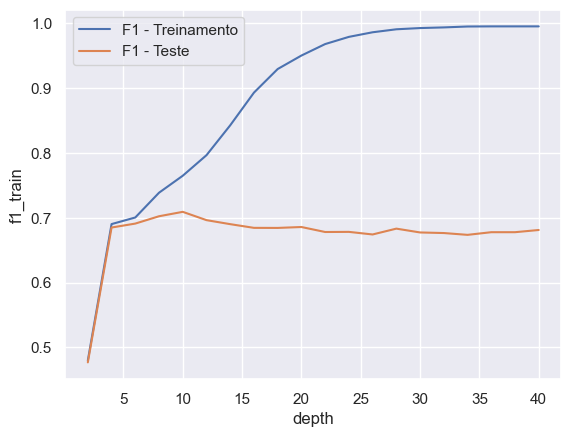

In [15]:
sns.lineplot(data = tb_rf_fit, x = 'depth', y = 'f1_train', label = "F1 - Treinamento")
sns.lineplot(data = tb_rf_fit, x = 'depth', y = 'f1_test', label = "F1 - Teste")

## Relação entre Tradeoff Viés-Variância e Overfitting

O tradeoff viés-variância está intimamente relacionado ao problema de overfitting em aprendizado de máquina.

- **Viés** refere-se ao erro introduzido ao aproximar um problema do mundo real com um modelo simplificado. Isso significa que um modelo com alto viés é provavelmente fazer suposições incorretas sobre as relações subjacentes nos dados, levando a underfitting e baixo desempenho preditivo.

- **Variância** refere-se à quantidade pela qual as previsões de um modelo mudariam se fosse treinado em um conjunto diferente de dados. Um modelo com alta variância é provavelmente capturar ruídos aleatórios nos dados de treinamento, levando a overfitting e má generalização para novos dados.

O tradeoff entre viés e variância surge porque modelos com mais complexidade podem ajustar os dados de treinamento mais precisamente (reduzindo o viés), mas são mais propensos a overfitting (aumentando a variância). Da mesma forma, modelos com menos complexidade são menos propensos a overfitting, mas podem não capturar todos os padrões relevantes nos dados (aumentando o viés).

Overfitting ocorre quando um modelo é muito complexo em relação à quantidade de dados de treinamento disponíveis, resultando em um modelo que ajusta os dados de treinamento muito bem, mas generaliza mal para novos dados não vistos. 

Técnicas de ensembling como bagging e boosting também podem ajudar a reduzir o overfitting, combinando vários modelos que são menos propensos a overfitting do que um único modelo mais complexo. 

- **Bagging** é uma técnica de ensemble que combina vários modelos independentes, treinados em diferentes subconjuntos aleatórios do conjunto de dados original. Isso reduz a variância do modelo final, porque cada modelo é treinado em um conjunto de dados diferente, tornando o modelo final menos suscetível a ruído aleatório no conjunto de dados.

- **Boosting** é uma técnica de ensemble que combina vários modelos fracos em um modelo forte. Ao contrário do bagging, que treina modelos independentes, o boosting treina cada modelo sequencialmente, dando mais peso aos exemplos de treinamento que foram classificados incorretamente pelo modelo anterior. Isso ajuda a reduzir o viés do modelo final, porque cada modelo subsequente é treinado para corrigir os erros do modelo anterior.

## Técnicas de Ensemble

Ensemble é uma técnica de aprendizado de máquina que combina vários modelos diferentes para melhorar a precisão e a robustez das previsões.

### Bagging

Bagging (Bootstrap Aggregating) foi proposto por Leo Breiman em 1996 como uma técnica para reduzir a variância dos modelos e evitar o overfitting. 

A ideia por trás do bagging é:
- criar várias instâncias do modelo base (por exemplo, árvore de decisão) treinando cada uma em uma amostra diferente do conjunto de dados de treinamento.
- selecionar essas amostras com substituição (bootstrap), o que significa que cada amostra é uma seleção aleatória do conjunto de dados de treinamento original.
- combinar as previsões de cada modelo por meio de votação para gerar uma única previsão final.

O bagging reduz a variância porque:
- as instâncias do modelo base treinadas em diferentes amostras de dados tendem a produzir previsões ligeiramente diferentes.
- a votação ajuda a combinar essas previsões em uma única previsão mais robusta.

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
rf_fit = RandomForestClassifier(n_estimators = 1500, max_depth= 3)
rf_fit.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=1500)

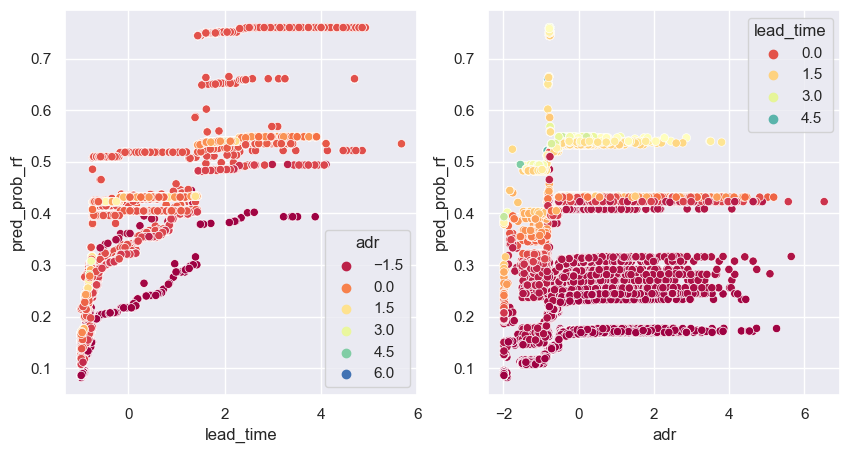

In [18]:
tb_fits["pred_prob_rf"] = rf_fit.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(
    data=tb_fits, 
    x="lead_time", y="pred_prob_rf", hue = "adr", 
    ax =ax[0], palette='Spectral')
sns.scatterplot(
    data=tb_fits, 
    x="adr", y="pred_prob_rf", hue = "lead_time", 
    ax = ax[1], palette = 'Spectral');



<Axes: >

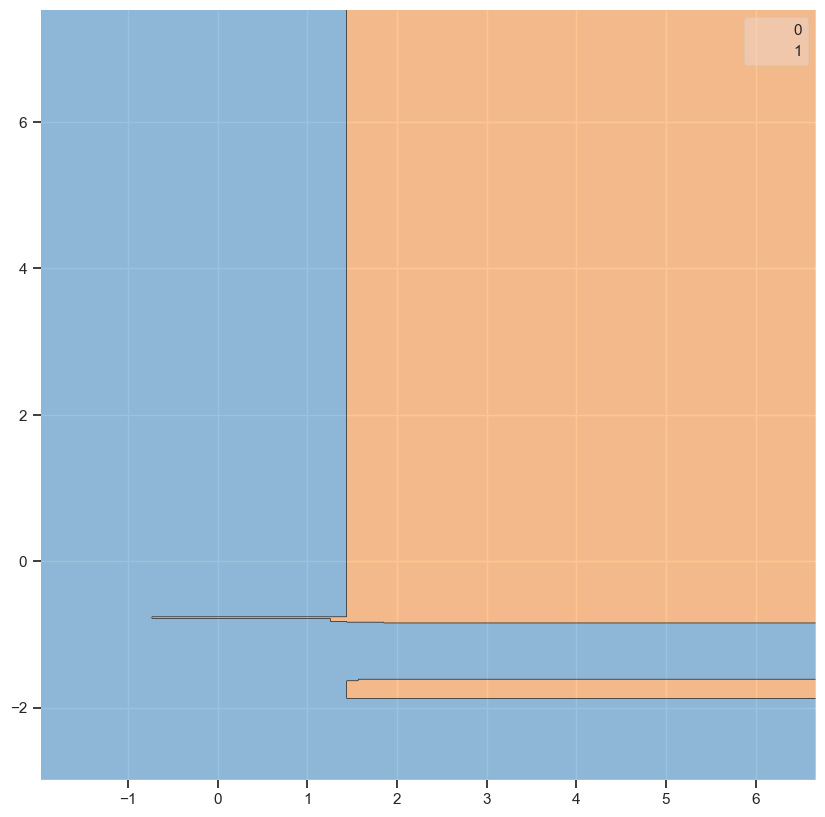

In [20]:
fig = plt.figure(figsize=(10, 10))
plot_decision_regions(
    np.array(tb_fits[["lead_time", "adr"]]),
    np.array(tb_fits["is_cancelled"]),
    rf_fit,
    scatter_kwargs={"alpha": 0.001},
)


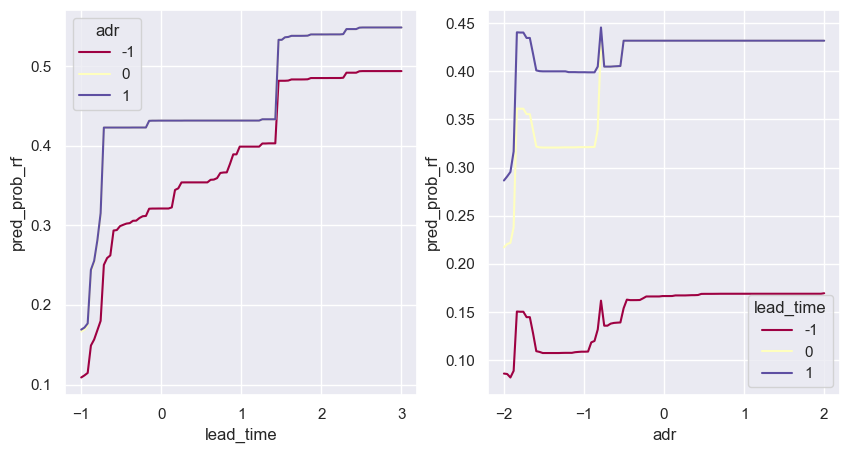

In [22]:
tb_simul_lt['pred_prob_rf'] = rf_fit.predict_proba(tb_simul_lt[x_var])[:,1]
tb_simul_adr['pred_prob_rf'] = rf_fit.predict_proba(tb_simul_adr[x_var])[:,1]
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.lineplot(
    data=tb_simul_lt, 
    x="lead_time", y="pred_prob_rf", hue = "adr", 
    ax =ax[0], palette='Spectral')
sns.lineplot(
    data=tb_simul_adr, 
    x="adr", y="pred_prob_rf", hue = "lead_time", 
    ax = ax[1], palette = 'Spectral');


### Boosting

Boosting foi proposto por Robert Schapire em 1990 e posteriormente desenvolvido por Yoav Freund e outros pesquisadores. 

O objetivo do boosting é melhorar a precisão do modelo base, enfatizando os exemplos de treinamento que foram mal previstos. 

A ideia é:
- treinar vários modelos fracos (por exemplo, uma árvore de decisão rasa) em diferentes subconjuntos dos dados de treinamento.
- atribuir pesos aos exemplos de treinamento com base em quão bem o modelo previu esses exemplos.
- os exemplos mal previstos recebem um peso maior, de modo que o modelo seguinte seja mais focado nesses exemplos e possa corrigir os erros anteriores.
- a previsão final é feita por meio da combinação das previsões de todos os modelos com base em seus pesos.

O boosting reduz o viés do modelo base, tornando-o mais preciso.

In [23]:
from catboost import CatBoostClassifier

In [26]:
cat_fit = CatBoostClassifier(iterations = 2500, depth=4) # depth varia entre 2 - 10 +/-, iterations 100-10000
cat_fit.fit(X_train, y_train, eval_set = (X_test, y_test))

Learning rate set to 0.063531
0:	learn: 0.6800228	test: 0.6800022	best: 0.6800022 (0)	total: 9.29ms	remaining: 23.2s
1:	learn: 0.6685734	test: 0.6684742	best: 0.6684742 (1)	total: 17ms	remaining: 21.2s
2:	learn: 0.6587280	test: 0.6587110	best: 0.6587110 (2)	total: 22.5ms	remaining: 18.7s
3:	learn: 0.6496967	test: 0.6496642	best: 0.6496642 (3)	total: 28.5ms	remaining: 17.8s
4:	learn: 0.6422603	test: 0.6421586	best: 0.6421586 (4)	total: 34.8ms	remaining: 17.4s
5:	learn: 0.6355347	test: 0.6354624	best: 0.6354624 (5)	total: 44.2ms	remaining: 18.4s
6:	learn: 0.6292982	test: 0.6288916	best: 0.6288916 (6)	total: 50.4ms	remaining: 18s
7:	learn: 0.6243296	test: 0.6239486	best: 0.6239486 (7)	total: 55.9ms	remaining: 17.4s
8:	learn: 0.6202238	test: 0.6198875	best: 0.6198875 (8)	total: 61.4ms	remaining: 17s
9:	learn: 0.6159181	test: 0.6152922	best: 0.6152922 (9)	total: 67.7ms	remaining: 16.8s
10:	learn: 0.6123649	test: 0.6117227	best: 0.6117227 (10)	total: 73.6ms	remaining: 16.7s
11:	learn: 0.6097

98:	learn: 0.5733633	test: 0.5723302	best: 0.5723302 (98)	total: 597ms	remaining: 14.5s
99:	learn: 0.5729647	test: 0.5718549	best: 0.5718549 (99)	total: 604ms	remaining: 14.5s
100:	learn: 0.5728177	test: 0.5717350	best: 0.5717350 (100)	total: 609ms	remaining: 14.5s
101:	learn: 0.5727023	test: 0.5716488	best: 0.5716488 (101)	total: 616ms	remaining: 14.5s
102:	learn: 0.5725805	test: 0.5714015	best: 0.5714015 (102)	total: 621ms	remaining: 14.5s
103:	learn: 0.5724362	test: 0.5712842	best: 0.5712842 (103)	total: 628ms	remaining: 14.5s
104:	learn: 0.5723154	test: 0.5711519	best: 0.5711519 (104)	total: 635ms	remaining: 14.5s
105:	learn: 0.5722069	test: 0.5710575	best: 0.5710575 (105)	total: 641ms	remaining: 14.5s
106:	learn: 0.5720849	test: 0.5710350	best: 0.5710350 (106)	total: 649ms	remaining: 14.5s
107:	learn: 0.5720278	test: 0.5709882	best: 0.5709882 (107)	total: 655ms	remaining: 14.5s
108:	learn: 0.5719654	test: 0.5709362	best: 0.5709362 (108)	total: 661ms	remaining: 14.5s
109:	learn: 0.

194:	learn: 0.5624870	test: 0.5629203	best: 0.5628970 (193)	total: 1.2s	remaining: 14.2s
195:	learn: 0.5624441	test: 0.5628987	best: 0.5628970 (193)	total: 1.21s	remaining: 14.2s
196:	learn: 0.5623675	test: 0.5628461	best: 0.5628461 (196)	total: 1.22s	remaining: 14.2s
197:	learn: 0.5622472	test: 0.5627274	best: 0.5627274 (197)	total: 1.22s	remaining: 14.2s
198:	learn: 0.5621944	test: 0.5626945	best: 0.5626945 (198)	total: 1.23s	remaining: 14.2s
199:	learn: 0.5620267	test: 0.5625641	best: 0.5625641 (199)	total: 1.23s	remaining: 14.2s
200:	learn: 0.5619039	test: 0.5624680	best: 0.5624680 (200)	total: 1.24s	remaining: 14.2s
201:	learn: 0.5618068	test: 0.5624013	best: 0.5624013 (201)	total: 1.25s	remaining: 14.2s
202:	learn: 0.5617494	test: 0.5623595	best: 0.5623595 (202)	total: 1.25s	remaining: 14.2s
203:	learn: 0.5617173	test: 0.5623480	best: 0.5623480 (203)	total: 1.26s	remaining: 14.2s
204:	learn: 0.5615510	test: 0.5622240	best: 0.5622240 (204)	total: 1.27s	remaining: 14.2s
205:	learn:

286:	learn: 0.5541556	test: 0.5558677	best: 0.5558677 (286)	total: 1.8s	remaining: 13.9s
287:	learn: 0.5540437	test: 0.5557466	best: 0.5557466 (287)	total: 1.81s	remaining: 13.9s
288:	learn: 0.5539656	test: 0.5556636	best: 0.5556636 (288)	total: 1.81s	remaining: 13.9s
289:	learn: 0.5538606	test: 0.5555781	best: 0.5555781 (289)	total: 1.82s	remaining: 13.9s
290:	learn: 0.5537091	test: 0.5554610	best: 0.5554610 (290)	total: 1.83s	remaining: 13.9s
291:	learn: 0.5536554	test: 0.5553928	best: 0.5553928 (291)	total: 1.83s	remaining: 13.9s
292:	learn: 0.5535782	test: 0.5553268	best: 0.5553268 (292)	total: 1.84s	remaining: 13.9s
293:	learn: 0.5534482	test: 0.5552359	best: 0.5552359 (293)	total: 1.85s	remaining: 13.9s
294:	learn: 0.5533430	test: 0.5553010	best: 0.5552359 (293)	total: 1.85s	remaining: 13.9s
295:	learn: 0.5533188	test: 0.5552979	best: 0.5552359 (293)	total: 1.86s	remaining: 13.8s
296:	learn: 0.5532769	test: 0.5552765	best: 0.5552359 (293)	total: 1.86s	remaining: 13.8s
297:	learn:

379:	learn: 0.5472334	test: 0.5509130	best: 0.5509130 (379)	total: 2.4s	remaining: 13.4s
380:	learn: 0.5472030	test: 0.5508769	best: 0.5508769 (380)	total: 2.41s	remaining: 13.4s
381:	learn: 0.5471436	test: 0.5508287	best: 0.5508287 (381)	total: 2.42s	remaining: 13.4s
382:	learn: 0.5470831	test: 0.5507643	best: 0.5507643 (382)	total: 2.43s	remaining: 13.4s
383:	learn: 0.5470612	test: 0.5507413	best: 0.5507413 (383)	total: 2.44s	remaining: 13.4s
384:	learn: 0.5470234	test: 0.5507168	best: 0.5507168 (384)	total: 2.44s	remaining: 13.4s
385:	learn: 0.5469508	test: 0.5506529	best: 0.5506529 (385)	total: 2.45s	remaining: 13.4s
386:	learn: 0.5468946	test: 0.5505981	best: 0.5505981 (386)	total: 2.46s	remaining: 13.4s
387:	learn: 0.5468298	test: 0.5505422	best: 0.5505422 (387)	total: 2.46s	remaining: 13.4s
388:	learn: 0.5467549	test: 0.5504685	best: 0.5504685 (388)	total: 2.47s	remaining: 13.4s
389:	learn: 0.5467213	test: 0.5504512	best: 0.5504512 (389)	total: 2.48s	remaining: 13.4s
390:	learn:

501:	learn: 0.5412026	test: 0.5464842	best: 0.5464842 (501)	total: 3.2s	remaining: 12.7s
502:	learn: 0.5411435	test: 0.5464874	best: 0.5464842 (501)	total: 3.2s	remaining: 12.7s
503:	learn: 0.5410760	test: 0.5464520	best: 0.5464520 (503)	total: 3.21s	remaining: 12.7s
504:	learn: 0.5409625	test: 0.5463261	best: 0.5463261 (504)	total: 3.22s	remaining: 12.7s
505:	learn: 0.5409163	test: 0.5463027	best: 0.5463027 (505)	total: 3.23s	remaining: 12.7s
506:	learn: 0.5408777	test: 0.5462564	best: 0.5462564 (506)	total: 3.23s	remaining: 12.7s
507:	learn: 0.5408077	test: 0.5462077	best: 0.5462077 (507)	total: 3.24s	remaining: 12.7s
508:	learn: 0.5407769	test: 0.5461899	best: 0.5461899 (508)	total: 3.25s	remaining: 12.7s
509:	learn: 0.5407493	test: 0.5462437	best: 0.5461899 (508)	total: 3.25s	remaining: 12.7s
510:	learn: 0.5407263	test: 0.5462336	best: 0.5461899 (508)	total: 3.26s	remaining: 12.7s
511:	learn: 0.5406669	test: 0.5461535	best: 0.5461535 (511)	total: 3.26s	remaining: 12.7s
512:	learn: 

595:	learn: 0.5372106	test: 0.5436929	best: 0.5436929 (595)	total: 3.81s	remaining: 12.2s
596:	learn: 0.5371309	test: 0.5436104	best: 0.5436104 (596)	total: 3.81s	remaining: 12.2s
597:	learn: 0.5371126	test: 0.5436034	best: 0.5436034 (597)	total: 3.82s	remaining: 12.2s
598:	learn: 0.5370575	test: 0.5435624	best: 0.5435624 (598)	total: 3.83s	remaining: 12.1s
599:	learn: 0.5370371	test: 0.5435504	best: 0.5435504 (599)	total: 3.83s	remaining: 12.1s
600:	learn: 0.5370101	test: 0.5435292	best: 0.5435292 (600)	total: 3.84s	remaining: 12.1s
601:	learn: 0.5369707	test: 0.5435028	best: 0.5435028 (601)	total: 3.85s	remaining: 12.1s
602:	learn: 0.5369356	test: 0.5434700	best: 0.5434700 (602)	total: 3.85s	remaining: 12.1s
603:	learn: 0.5369133	test: 0.5434415	best: 0.5434415 (603)	total: 3.86s	remaining: 12.1s
604:	learn: 0.5368784	test: 0.5433880	best: 0.5433880 (604)	total: 3.87s	remaining: 12.1s
605:	learn: 0.5368448	test: 0.5433486	best: 0.5433486 (605)	total: 3.87s	remaining: 12.1s
606:	learn

714:	learn: 0.5325494	test: 0.5400534	best: 0.5400534 (714)	total: 4.61s	remaining: 11.5s
715:	learn: 0.5325327	test: 0.5400450	best: 0.5400450 (715)	total: 4.62s	remaining: 11.5s
716:	learn: 0.5324608	test: 0.5399891	best: 0.5399891 (716)	total: 4.63s	remaining: 11.5s
717:	learn: 0.5324437	test: 0.5399823	best: 0.5399823 (717)	total: 4.63s	remaining: 11.5s
718:	learn: 0.5324233	test: 0.5399807	best: 0.5399807 (718)	total: 4.64s	remaining: 11.5s
719:	learn: 0.5323803	test: 0.5399135	best: 0.5399135 (719)	total: 4.65s	remaining: 11.5s
720:	learn: 0.5323454	test: 0.5398498	best: 0.5398498 (720)	total: 4.65s	remaining: 11.5s
721:	learn: 0.5323336	test: 0.5398391	best: 0.5398391 (721)	total: 4.66s	remaining: 11.5s
722:	learn: 0.5322906	test: 0.5398103	best: 0.5398103 (722)	total: 4.67s	remaining: 11.5s
723:	learn: 0.5322599	test: 0.5397896	best: 0.5397896 (723)	total: 4.68s	remaining: 11.5s
724:	learn: 0.5322111	test: 0.5397452	best: 0.5397452 (724)	total: 4.68s	remaining: 11.5s
725:	learn

832:	learn: 0.5290266	test: 0.5379490	best: 0.5379490 (832)	total: 5.42s	remaining: 10.8s
833:	learn: 0.5290030	test: 0.5378743	best: 0.5378743 (833)	total: 5.43s	remaining: 10.8s
834:	learn: 0.5289823	test: 0.5378075	best: 0.5378075 (834)	total: 5.43s	remaining: 10.8s
835:	learn: 0.5289361	test: 0.5377807	best: 0.5377807 (835)	total: 5.44s	remaining: 10.8s
836:	learn: 0.5289070	test: 0.5377727	best: 0.5377727 (836)	total: 5.45s	remaining: 10.8s
837:	learn: 0.5289019	test: 0.5377734	best: 0.5377727 (836)	total: 5.46s	remaining: 10.8s
838:	learn: 0.5288891	test: 0.5378377	best: 0.5377727 (836)	total: 5.47s	remaining: 10.8s
839:	learn: 0.5288665	test: 0.5378178	best: 0.5377727 (836)	total: 5.47s	remaining: 10.8s
840:	learn: 0.5288557	test: 0.5378187	best: 0.5377727 (836)	total: 5.48s	remaining: 10.8s
841:	learn: 0.5288314	test: 0.5378036	best: 0.5377727 (836)	total: 5.49s	remaining: 10.8s
842:	learn: 0.5288124	test: 0.5377934	best: 0.5377727 (836)	total: 5.49s	remaining: 10.8s
843:	learn

949:	learn: 0.5259074	test: 0.5356952	best: 0.5356919 (948)	total: 6.22s	remaining: 10.2s
950:	learn: 0.5258797	test: 0.5356621	best: 0.5356621 (950)	total: 6.23s	remaining: 10.1s
951:	learn: 0.5258088	test: 0.5356172	best: 0.5356172 (951)	total: 6.23s	remaining: 10.1s
952:	learn: 0.5257908	test: 0.5356055	best: 0.5356055 (952)	total: 6.24s	remaining: 10.1s
953:	learn: 0.5257472	test: 0.5355765	best: 0.5355765 (953)	total: 6.25s	remaining: 10.1s
954:	learn: 0.5257340	test: 0.5355729	best: 0.5355729 (954)	total: 6.25s	remaining: 10.1s
955:	learn: 0.5257027	test: 0.5355575	best: 0.5355575 (955)	total: 6.26s	remaining: 10.1s
956:	learn: 0.5256862	test: 0.5355333	best: 0.5355333 (956)	total: 6.27s	remaining: 10.1s
957:	learn: 0.5256081	test: 0.5354708	best: 0.5354708 (957)	total: 6.27s	remaining: 10.1s
958:	learn: 0.5255901	test: 0.5355158	best: 0.5354708 (957)	total: 6.28s	remaining: 10.1s
959:	learn: 0.5255823	test: 0.5355440	best: 0.5354708 (957)	total: 6.29s	remaining: 10.1s
960:	learn

1041:	learn: 0.5236346	test: 0.5337075	best: 0.5337075 (1041)	total: 6.83s	remaining: 9.56s
1042:	learn: 0.5236032	test: 0.5336937	best: 0.5336937 (1042)	total: 6.84s	remaining: 9.56s
1043:	learn: 0.5235856	test: 0.5336895	best: 0.5336895 (1043)	total: 6.85s	remaining: 9.55s
1044:	learn: 0.5235427	test: 0.5336693	best: 0.5336693 (1044)	total: 6.86s	remaining: 9.55s
1045:	learn: 0.5235227	test: 0.5336500	best: 0.5336500 (1045)	total: 6.87s	remaining: 9.54s
1046:	learn: 0.5234776	test: 0.5336002	best: 0.5336002 (1046)	total: 6.87s	remaining: 9.54s
1047:	learn: 0.5234589	test: 0.5335863	best: 0.5335863 (1047)	total: 6.88s	remaining: 9.53s
1048:	learn: 0.5234504	test: 0.5336007	best: 0.5335863 (1047)	total: 6.88s	remaining: 9.52s
1049:	learn: 0.5234075	test: 0.5335489	best: 0.5335489 (1049)	total: 6.89s	remaining: 9.52s
1050:	learn: 0.5233984	test: 0.5335458	best: 0.5335458 (1050)	total: 6.89s	remaining: 9.51s
1051:	learn: 0.5233780	test: 0.5335126	best: 0.5335126 (1051)	total: 6.9s	remain

1135:	learn: 0.5214892	test: 0.5320983	best: 0.5320983 (1135)	total: 7.43s	remaining: 8.92s
1136:	learn: 0.5214695	test: 0.5320815	best: 0.5320815 (1136)	total: 7.44s	remaining: 8.91s
1137:	learn: 0.5214564	test: 0.5321068	best: 0.5320815 (1136)	total: 7.44s	remaining: 8.91s
1138:	learn: 0.5214205	test: 0.5321959	best: 0.5320815 (1136)	total: 7.45s	remaining: 8.9s
1139:	learn: 0.5214005	test: 0.5321812	best: 0.5320815 (1136)	total: 7.46s	remaining: 8.89s
1140:	learn: 0.5213880	test: 0.5321861	best: 0.5320815 (1136)	total: 7.46s	remaining: 8.89s
1141:	learn: 0.5213793	test: 0.5321796	best: 0.5320815 (1136)	total: 7.47s	remaining: 8.88s
1142:	learn: 0.5213639	test: 0.5321754	best: 0.5320815 (1136)	total: 7.48s	remaining: 8.88s
1143:	learn: 0.5213581	test: 0.5321771	best: 0.5320815 (1136)	total: 7.48s	remaining: 8.87s
1144:	learn: 0.5213367	test: 0.5321702	best: 0.5320815 (1136)	total: 7.49s	remaining: 8.86s
1145:	learn: 0.5213231	test: 0.5321518	best: 0.5320815 (1136)	total: 7.49s	remain

1231:	learn: 0.5193808	test: 0.5309076	best: 0.5309076 (1231)	total: 8.03s	remaining: 8.27s
1232:	learn: 0.5193751	test: 0.5309053	best: 0.5309053 (1232)	total: 8.04s	remaining: 8.26s
1233:	learn: 0.5193670	test: 0.5309784	best: 0.5309053 (1232)	total: 8.05s	remaining: 8.26s
1234:	learn: 0.5193593	test: 0.5309721	best: 0.5309053 (1232)	total: 8.06s	remaining: 8.25s
1235:	learn: 0.5193227	test: 0.5309354	best: 0.5309053 (1232)	total: 8.06s	remaining: 8.25s
1236:	learn: 0.5193020	test: 0.5309316	best: 0.5309053 (1232)	total: 8.07s	remaining: 8.24s
1237:	learn: 0.5192935	test: 0.5309215	best: 0.5309053 (1232)	total: 8.07s	remaining: 8.23s
1238:	learn: 0.5192676	test: 0.5308978	best: 0.5308978 (1238)	total: 8.08s	remaining: 8.23s
1239:	learn: 0.5192456	test: 0.5308790	best: 0.5308790 (1239)	total: 8.09s	remaining: 8.22s
1240:	learn: 0.5191920	test: 0.5308288	best: 0.5308288 (1240)	total: 8.1s	remaining: 8.21s
1241:	learn: 0.5191618	test: 0.5308117	best: 0.5308117 (1241)	total: 8.1s	remaini

1324:	learn: 0.5175428	test: 0.5293370	best: 0.5293084 (1318)	total: 8.64s	remaining: 7.66s
1325:	learn: 0.5175250	test: 0.5293196	best: 0.5293084 (1318)	total: 8.64s	remaining: 7.65s
1326:	learn: 0.5175048	test: 0.5292755	best: 0.5292755 (1326)	total: 8.65s	remaining: 7.65s
1327:	learn: 0.5174968	test: 0.5292638	best: 0.5292638 (1327)	total: 8.66s	remaining: 7.64s
1328:	learn: 0.5174334	test: 0.5291638	best: 0.5291638 (1328)	total: 8.67s	remaining: 7.64s
1329:	learn: 0.5174089	test: 0.5291482	best: 0.5291482 (1329)	total: 8.67s	remaining: 7.63s
1330:	learn: 0.5173742	test: 0.5293017	best: 0.5291482 (1329)	total: 8.68s	remaining: 7.62s
1331:	learn: 0.5173560	test: 0.5293240	best: 0.5291482 (1329)	total: 8.69s	remaining: 7.62s
1332:	learn: 0.5173354	test: 0.5293258	best: 0.5291482 (1329)	total: 8.7s	remaining: 7.61s
1333:	learn: 0.5173280	test: 0.5293305	best: 0.5291482 (1329)	total: 8.7s	remaining: 7.61s
1334:	learn: 0.5173091	test: 0.5293283	best: 0.5291482 (1329)	total: 8.71s	remaini

1414:	learn: 0.5159442	test: 0.5284826	best: 0.5284625 (1407)	total: 9.25s	remaining: 7.09s
1415:	learn: 0.5159322	test: 0.5284800	best: 0.5284625 (1407)	total: 9.25s	remaining: 7.08s
1416:	learn: 0.5159218	test: 0.5284777	best: 0.5284625 (1407)	total: 9.26s	remaining: 7.08s
1417:	learn: 0.5158910	test: 0.5284780	best: 0.5284625 (1407)	total: 9.27s	remaining: 7.07s
1418:	learn: 0.5158836	test: 0.5284881	best: 0.5284625 (1407)	total: 9.27s	remaining: 7.06s
1419:	learn: 0.5158722	test: 0.5284737	best: 0.5284625 (1407)	total: 9.28s	remaining: 7.06s
1420:	learn: 0.5158611	test: 0.5284679	best: 0.5284625 (1407)	total: 9.29s	remaining: 7.05s
1421:	learn: 0.5158444	test: 0.5284503	best: 0.5284503 (1421)	total: 9.29s	remaining: 7.04s
1422:	learn: 0.5158227	test: 0.5284556	best: 0.5284503 (1421)	total: 9.3s	remaining: 7.04s
1423:	learn: 0.5158077	test: 0.5284607	best: 0.5284503 (1421)	total: 9.3s	remaining: 7.03s
1424:	learn: 0.5157910	test: 0.5284529	best: 0.5284503 (1421)	total: 9.31s	remaini

1504:	learn: 0.5144079	test: 0.5274830	best: 0.5274675 (1503)	total: 9.85s	remaining: 6.51s
1505:	learn: 0.5143878	test: 0.5274682	best: 0.5274675 (1503)	total: 9.86s	remaining: 6.5s
1506:	learn: 0.5143714	test: 0.5274690	best: 0.5274675 (1503)	total: 9.86s	remaining: 6.5s
1507:	learn: 0.5143605	test: 0.5274682	best: 0.5274675 (1503)	total: 9.87s	remaining: 6.49s
1508:	learn: 0.5143521	test: 0.5274518	best: 0.5274518 (1508)	total: 9.88s	remaining: 6.49s
1509:	learn: 0.5143411	test: 0.5274417	best: 0.5274417 (1509)	total: 9.88s	remaining: 6.48s
1510:	learn: 0.5143088	test: 0.5274232	best: 0.5274232 (1510)	total: 9.89s	remaining: 6.47s
1511:	learn: 0.5142847	test: 0.5274160	best: 0.5274160 (1511)	total: 9.9s	remaining: 6.47s
1512:	learn: 0.5142711	test: 0.5274158	best: 0.5274158 (1512)	total: 9.9s	remaining: 6.46s
1513:	learn: 0.5142589	test: 0.5274891	best: 0.5274158 (1512)	total: 9.91s	remaining: 6.45s
1514:	learn: 0.5142263	test: 0.5274515	best: 0.5274158 (1512)	total: 9.91s	remaining

1600:	learn: 0.5126524	test: 0.5265228	best: 0.5264893 (1594)	total: 10.5s	remaining: 5.87s
1601:	learn: 0.5126359	test: 0.5265284	best: 0.5264893 (1594)	total: 10.5s	remaining: 5.86s
1602:	learn: 0.5126315	test: 0.5265261	best: 0.5264893 (1594)	total: 10.5s	remaining: 5.86s
1603:	learn: 0.5126159	test: 0.5265190	best: 0.5264893 (1594)	total: 10.5s	remaining: 5.85s
1604:	learn: 0.5126061	test: 0.5265120	best: 0.5264893 (1594)	total: 10.5s	remaining: 5.84s
1605:	learn: 0.5126018	test: 0.5265059	best: 0.5264893 (1594)	total: 10.5s	remaining: 5.84s
1606:	learn: 0.5125890	test: 0.5264979	best: 0.5264893 (1594)	total: 10.5s	remaining: 5.83s
1607:	learn: 0.5125778	test: 0.5264911	best: 0.5264893 (1594)	total: 10.5s	remaining: 5.82s
1608:	learn: 0.5125590	test: 0.5264728	best: 0.5264728 (1608)	total: 10.5s	remaining: 5.82s
1609:	learn: 0.5125515	test: 0.5265556	best: 0.5264728 (1608)	total: 10.5s	remaining: 5.81s
1610:	learn: 0.5125424	test: 0.5265507	best: 0.5264728 (1608)	total: 10.5s	remai

1693:	learn: 0.5113099	test: 0.5257902	best: 0.5257902 (1693)	total: 11.1s	remaining: 5.26s
1694:	learn: 0.5112968	test: 0.5257823	best: 0.5257823 (1694)	total: 11.1s	remaining: 5.26s
1695:	learn: 0.5112883	test: 0.5257842	best: 0.5257823 (1694)	total: 11.1s	remaining: 5.25s
1696:	learn: 0.5112756	test: 0.5258545	best: 0.5257823 (1694)	total: 11.1s	remaining: 5.24s
1697:	learn: 0.5112695	test: 0.5257141	best: 0.5257141 (1697)	total: 11.1s	remaining: 5.24s
1698:	learn: 0.5112622	test: 0.5257025	best: 0.5257025 (1698)	total: 11.1s	remaining: 5.23s
1699:	learn: 0.5112464	test: 0.5256935	best: 0.5256935 (1699)	total: 11.1s	remaining: 5.22s
1700:	learn: 0.5112427	test: 0.5256889	best: 0.5256889 (1700)	total: 11.1s	remaining: 5.22s
1701:	learn: 0.5112389	test: 0.5256873	best: 0.5256873 (1701)	total: 11.1s	remaining: 5.21s
1702:	learn: 0.5112224	test: 0.5256703	best: 0.5256703 (1702)	total: 11.1s	remaining: 5.21s
1703:	learn: 0.5112020	test: 0.5256424	best: 0.5256424 (1703)	total: 11.1s	remai

1784:	learn: 0.5100366	test: 0.5250601	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.67s
1785:	learn: 0.5100324	test: 0.5250627	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.67s
1786:	learn: 0.5100230	test: 0.5250703	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.66s
1787:	learn: 0.5100193	test: 0.5250466	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.65s
1788:	learn: 0.5100089	test: 0.5250756	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.65s
1789:	learn: 0.5099836	test: 0.5250612	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.64s
1790:	learn: 0.5099758	test: 0.5250537	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.64s
1791:	learn: 0.5099700	test: 0.5250515	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.63s
1792:	learn: 0.5099556	test: 0.5250458	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.62s
1793:	learn: 0.5099454	test: 0.5250527	best: 0.5249808 (1782)	total: 11.7s	remaining: 4.62s
1794:	learn: 0.5099279	test: 0.5250362	best: 0.5249808 (1782)	total: 11.7s	remai

1875:	learn: 0.5087451	test: 0.5243161	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.08s
1876:	learn: 0.5087399	test: 0.5243179	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.07s
1877:	learn: 0.5087157	test: 0.5242936	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.07s
1878:	learn: 0.5087104	test: 0.5242862	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.06s
1879:	learn: 0.5086967	test: 0.5242783	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.05s
1880:	learn: 0.5086647	test: 0.5242590	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.05s
1881:	learn: 0.5086541	test: 0.5242543	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.04s
1882:	learn: 0.5086297	test: 0.5242025	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.04s
1883:	learn: 0.5086135	test: 0.5241903	best: 0.5241841 (1866)	total: 12.3s	remaining: 4.03s
1884:	learn: 0.5086012	test: 0.5241729	best: 0.5241729 (1884)	total: 12.3s	remaining: 4.02s
1885:	learn: 0.5085898	test: 0.5240635	best: 0.5240635 (1885)	total: 12.3s	remai

1965:	learn: 0.5073180	test: 0.5232193	best: 0.5232193 (1965)	total: 12.9s	remaining: 3.5s
1966:	learn: 0.5073088	test: 0.5232131	best: 0.5232131 (1966)	total: 12.9s	remaining: 3.49s
1967:	learn: 0.5072957	test: 0.5232149	best: 0.5232131 (1966)	total: 12.9s	remaining: 3.48s
1968:	learn: 0.5072813	test: 0.5232050	best: 0.5232050 (1968)	total: 12.9s	remaining: 3.48s
1969:	learn: 0.5072737	test: 0.5231944	best: 0.5231944 (1969)	total: 12.9s	remaining: 3.47s
1970:	learn: 0.5072580	test: 0.5231635	best: 0.5231635 (1970)	total: 12.9s	remaining: 3.46s
1971:	learn: 0.5072540	test: 0.5231657	best: 0.5231635 (1970)	total: 12.9s	remaining: 3.46s
1972:	learn: 0.5072462	test: 0.5231691	best: 0.5231635 (1970)	total: 12.9s	remaining: 3.45s
1973:	learn: 0.5072362	test: 0.5231632	best: 0.5231632 (1973)	total: 12.9s	remaining: 3.44s
1974:	learn: 0.5072254	test: 0.5231555	best: 0.5231555 (1974)	total: 12.9s	remaining: 3.44s
1975:	learn: 0.5072181	test: 0.5231307	best: 0.5231307 (1975)	total: 12.9s	remain

2059:	learn: 0.5060279	test: 0.5225525	best: 0.5225525 (2059)	total: 13.5s	remaining: 2.88s
2060:	learn: 0.5060217	test: 0.5225510	best: 0.5225510 (2060)	total: 13.5s	remaining: 2.87s
2061:	learn: 0.5060128	test: 0.5225484	best: 0.5225484 (2061)	total: 13.5s	remaining: 2.86s
2062:	learn: 0.5060081	test: 0.5225721	best: 0.5225484 (2061)	total: 13.5s	remaining: 2.86s
2063:	learn: 0.5059633	test: 0.5225329	best: 0.5225329 (2063)	total: 13.5s	remaining: 2.85s
2064:	learn: 0.5059501	test: 0.5225347	best: 0.5225329 (2063)	total: 13.5s	remaining: 2.85s
2065:	learn: 0.5059344	test: 0.5225119	best: 0.5225119 (2065)	total: 13.5s	remaining: 2.84s
2066:	learn: 0.5059193	test: 0.5225020	best: 0.5225020 (2066)	total: 13.5s	remaining: 2.83s
2067:	learn: 0.5059122	test: 0.5225009	best: 0.5225009 (2067)	total: 13.5s	remaining: 2.83s
2068:	learn: 0.5059076	test: 0.5224813	best: 0.5224813 (2068)	total: 13.5s	remaining: 2.82s
2069:	learn: 0.5058997	test: 0.5225072	best: 0.5224813 (2068)	total: 13.5s	remai

2152:	learn: 0.5047049	test: 0.5219966	best: 0.5219966 (2152)	total: 14.1s	remaining: 2.27s
2153:	learn: 0.5046967	test: 0.5219798	best: 0.5219798 (2153)	total: 14.1s	remaining: 2.26s
2154:	learn: 0.5046751	test: 0.5219706	best: 0.5219706 (2154)	total: 14.1s	remaining: 2.26s
2155:	learn: 0.5046723	test: 0.5219730	best: 0.5219706 (2154)	total: 14.1s	remaining: 2.25s
2156:	learn: 0.5046530	test: 0.5219545	best: 0.5219545 (2156)	total: 14.1s	remaining: 2.24s
2157:	learn: 0.5046426	test: 0.5219459	best: 0.5219459 (2157)	total: 14.1s	remaining: 2.24s
2158:	learn: 0.5046281	test: 0.5219301	best: 0.5219301 (2158)	total: 14.1s	remaining: 2.23s
2159:	learn: 0.5046267	test: 0.5219387	best: 0.5219301 (2158)	total: 14.1s	remaining: 2.22s
2160:	learn: 0.5046225	test: 0.5219355	best: 0.5219301 (2158)	total: 14.1s	remaining: 2.22s
2161:	learn: 0.5046166	test: 0.5219391	best: 0.5219301 (2158)	total: 14.1s	remaining: 2.21s
2162:	learn: 0.5045733	test: 0.5219210	best: 0.5219210 (2162)	total: 14.1s	remai

2242:	learn: 0.5033452	test: 0.5211124	best: 0.5211124 (2242)	total: 14.7s	remaining: 1.68s
2243:	learn: 0.5033339	test: 0.5211129	best: 0.5211124 (2242)	total: 14.7s	remaining: 1.68s
2244:	learn: 0.5033164	test: 0.5211228	best: 0.5211124 (2242)	total: 14.7s	remaining: 1.67s
2245:	learn: 0.5033064	test: 0.5211091	best: 0.5211091 (2245)	total: 14.7s	remaining: 1.66s
2246:	learn: 0.5032998	test: 0.5211141	best: 0.5211091 (2245)	total: 14.7s	remaining: 1.66s
2247:	learn: 0.5032935	test: 0.5211175	best: 0.5211091 (2245)	total: 14.7s	remaining: 1.65s
2248:	learn: 0.5032902	test: 0.5211181	best: 0.5211091 (2245)	total: 14.7s	remaining: 1.64s
2249:	learn: 0.5032819	test: 0.5211205	best: 0.5211091 (2245)	total: 14.7s	remaining: 1.64s
2250:	learn: 0.5032754	test: 0.5211227	best: 0.5211091 (2245)	total: 14.7s	remaining: 1.63s
2251:	learn: 0.5032328	test: 0.5210977	best: 0.5210977 (2251)	total: 14.8s	remaining: 1.62s
2252:	learn: 0.5031860	test: 0.5210518	best: 0.5210518 (2252)	total: 14.8s	remai

2357:	learn: 0.5020743	test: 0.5208257	best: 0.5207554 (2331)	total: 15.5s	remaining: 933ms
2358:	learn: 0.5020503	test: 0.5207965	best: 0.5207554 (2331)	total: 15.5s	remaining: 927ms
2359:	learn: 0.5020378	test: 0.5207948	best: 0.5207554 (2331)	total: 15.5s	remaining: 920ms
2360:	learn: 0.5020318	test: 0.5207942	best: 0.5207554 (2331)	total: 15.5s	remaining: 913ms
2361:	learn: 0.5020227	test: 0.5207856	best: 0.5207554 (2331)	total: 15.5s	remaining: 907ms
2362:	learn: 0.5020169	test: 0.5207832	best: 0.5207554 (2331)	total: 15.5s	remaining: 900ms
2363:	learn: 0.5020131	test: 0.5207814	best: 0.5207554 (2331)	total: 15.5s	remaining: 894ms
2364:	learn: 0.5019938	test: 0.5207620	best: 0.5207554 (2331)	total: 15.5s	remaining: 887ms
2365:	learn: 0.5019908	test: 0.5207640	best: 0.5207554 (2331)	total: 15.5s	remaining: 881ms
2366:	learn: 0.5019800	test: 0.5207522	best: 0.5207522 (2366)	total: 15.6s	remaining: 874ms
2367:	learn: 0.5019626	test: 0.5207408	best: 0.5207408 (2367)	total: 15.6s	remai

2449:	learn: 0.5009247	test: 0.5202713	best: 0.5202713 (2449)	total: 16.1s	remaining: 329ms
2450:	learn: 0.5009203	test: 0.5202730	best: 0.5202713 (2449)	total: 16.1s	remaining: 322ms
2451:	learn: 0.5009101	test: 0.5202746	best: 0.5202713 (2449)	total: 16.1s	remaining: 315ms
2452:	learn: 0.5009030	test: 0.5202664	best: 0.5202664 (2452)	total: 16.1s	remaining: 309ms
2453:	learn: 0.5009009	test: 0.5202574	best: 0.5202574 (2453)	total: 16.1s	remaining: 302ms
2454:	learn: 0.5008926	test: 0.5202505	best: 0.5202505 (2454)	total: 16.1s	remaining: 296ms
2455:	learn: 0.5008507	test: 0.5202099	best: 0.5202099 (2455)	total: 16.1s	remaining: 289ms
2456:	learn: 0.5008457	test: 0.5202734	best: 0.5202099 (2455)	total: 16.1s	remaining: 283ms
2457:	learn: 0.5008337	test: 0.5202618	best: 0.5202099 (2455)	total: 16.2s	remaining: 276ms
2458:	learn: 0.5008316	test: 0.5202580	best: 0.5202099 (2455)	total: 16.2s	remaining: 269ms
2459:	learn: 0.5008287	test: 0.5202555	best: 0.5202099 (2455)	total: 16.2s	remai

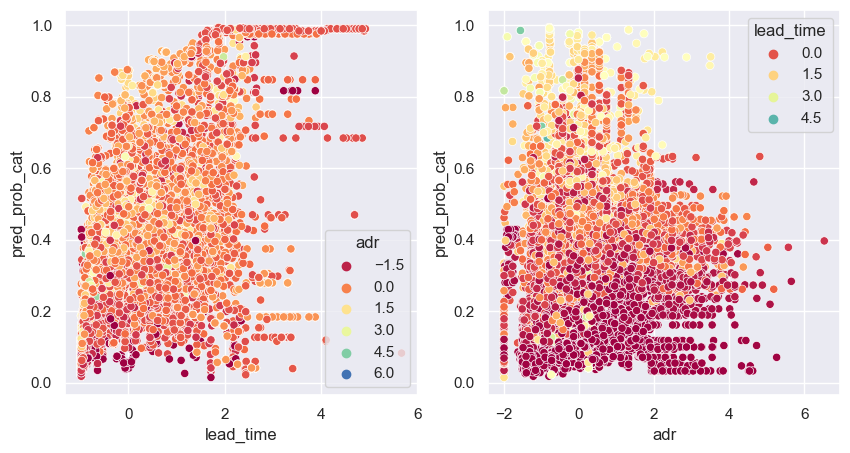

In [27]:
tb_fits["pred_prob_cat"] = cat_fit.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(
    data=tb_fits, 
    x="lead_time", y="pred_prob_cat", hue = "adr", 
    ax =ax[0], palette='Spectral')
sns.scatterplot(
    data=tb_fits, 
    x="adr", y="pred_prob_cat", hue = "lead_time", 
    ax = ax[1], palette = 'Spectral');

<Axes: >

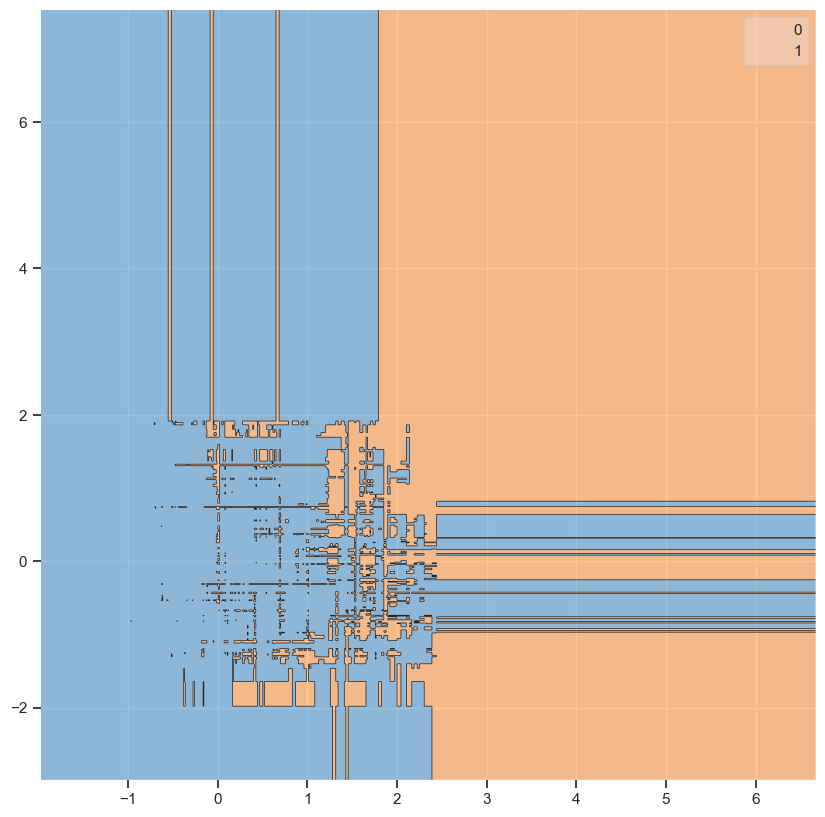

In [28]:
fig = plt.figure(figsize=(10, 10))
plot_decision_regions(
    np.array(tb_fits[["lead_time", "adr"]]),
    np.array(tb_fits["is_cancelled"]),
    cat_fit,
    scatter_kwargs={"alpha": 0.001},
)


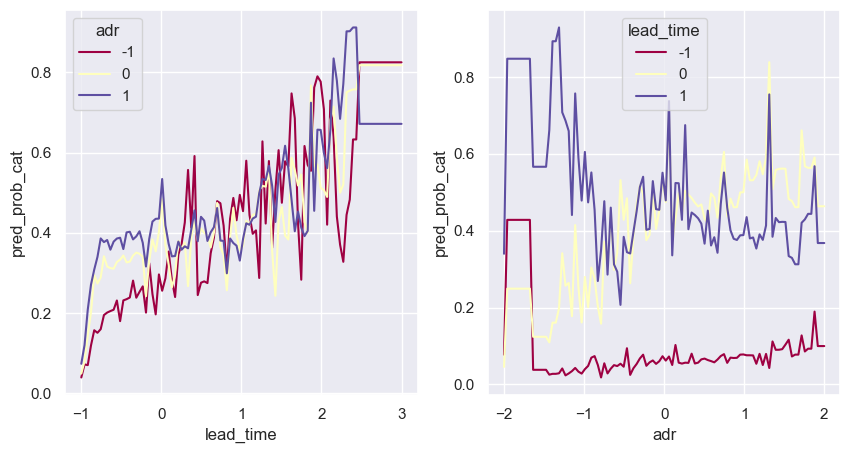

In [29]:
tb_simul_lt['pred_prob_cat'] = cat_fit.predict_proba(tb_simul_lt[x_var])[:,1]
tb_simul_adr['pred_prob_cat'] = cat_fit.predict_proba(tb_simul_adr[x_var])[:,1]
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.lineplot(
    data=tb_simul_lt, 
    x="lead_time", y="pred_prob_cat", hue = "adr", 
    ax =ax[0], palette='Spectral')
sns.lineplot(
    data=tb_simul_adr, 
    x="adr", y="pred_prob_cat", hue = "lead_time", 
    ax = ax[1], palette = 'Spectral');

### Escolha entre Bagging e Boosting

Em geral, o bagging é preferido quando o modelo base é propenso a overfitting, enquanto o boosting é preferido quando o modelo base é muito simples e tem alto viés.

Ambas as técnicas são muito usadas em problemas de aprendizado de máquina e continuam sendo áreas ativas de pesquisa.